Файл train.parquet успешно загружен.
Файл test.parquet успешно загружен.
Файл sample_submission.csv успешно загружен.
Данные train.parquet успешно загружены.
Данные test.parquet успешно загружены.
Данные sample_submission.csv успешно загружены.

Столбцы в train_data: ['id', 'dates', 'values', 'label']
Столбцы в test_data: ['id', 'dates', 'values']
Столбцы в sample_submission: ['id', 'score']

Первые строки train_data:
      id                                              dates  \
0  19114  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
1  22769  [2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...   
2  76935  [2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...   
3  66297  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
4   2191  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   

                                              values  label  
0  [-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....    0.0  
1  [-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...    1.0  
2  [0.28, 0.6

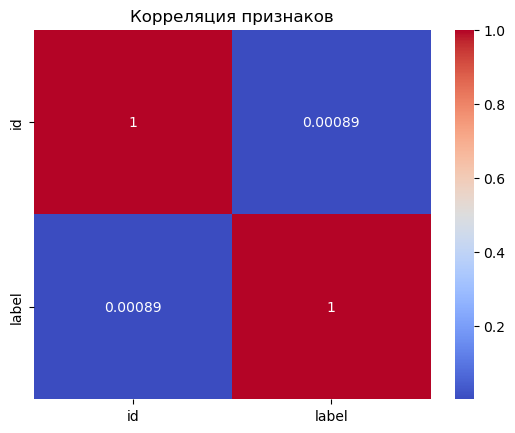


Средний ROC AUC для XGBoost (5-фолдовая кросс-валидация): 0.5
Средний ROC AUC для логистической регрессии (5-фолдовая кросс-валидация): 0.5
Корреляция между 'values_mean' и целевой переменной: nan
Корреляция между 'values_std' и целевой переменной: nan

Файл submission.csv успешно создан.
Файл submission.csv готов к скачиванию.


D:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
D:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


C:\Users\Артем\submission.csv

In [9]:
!pip install pyarrow
!pip install xgboost

# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import io
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import requests
import shutil

# Функция для загрузки файлов с GitHub
def download_file(url, save_path):
    response = requests.get(url)
    if response.status_code == 200:
        with open(save_path, 'wb') as f:
            f.write(response.content)
        print(f"Файл {save_path} успешно загружен.")
    else:
        print(f"Ошибка при загрузке файла {save_path}: {response.status_code}")

# Загрузка файлов с GitHub
url_train = "https://github.com/Mechanic17/time_series_classification/raw/refs/heads/main/train.parquet"
url_test = "https://github.com/Mechanic17/time_series_classification/raw/refs/heads/main/test.parquet"
url_sample_submission = "https://raw.githubusercontent.com/Mechanic17/time_series_classification/refs/heads/main/sample_submission.csv"

download_file(url_train, 'train.parquet')
download_file(url_test, 'test.parquet')
download_file(url_sample_submission, 'sample_submission.csv')

# Проверяем наличие файлов и читаем их
try:
    train_data = pd.read_parquet('train.parquet')
    print("Данные train.parquet успешно загружены.")
except FileNotFoundError:
    print("Файл train.parquet не найден.")

try:
    test_data = pd.read_parquet('test.parquet')
    print("Данные test.parquet успешно загружены.")
except FileNotFoundError:
    print("Файл test.parquet не найден.")

try:
    sample_submission = pd.read_csv('sample_submission.csv')
    print("Данные sample_submission.csv успешно загружены.")
except FileNotFoundError:
    print("Файл sample_submission.csv не найден.")

# Проверяем столбцы в каждом наборе данных
print("\nСтолбцы в train_data:", train_data.columns.tolist())
print("Столбцы в test_data:", test_data.columns.tolist())
print("Столбцы в sample_submission:", sample_submission.columns.tolist())

# Шаг 2: EDA - Анализ данных
print("\nПервые строки train_data:")
print(train_data.head())

print("\nИнформация о train_data:")
print(train_data.info())

print("\nОписание числовых признаков train_data:")
print(train_data.describe())

# Распределение целевой переменной
print("\nРаспределение целевой переменной 'label':")
print(train_data['label'].value_counts())

# Проверка корреляции признаков
numerical_data = train_data.select_dtypes(include=[np.number])
sns.heatmap(numerical_data.corr(), annot=True, cmap='coolwarm')
plt.title("Корреляция признаков")
plt.show()

# Шаг 3: Предобработка данных

# Сохраняем 'id' из test_data для формирования файла submission.csv
test_ids = test_data['id']

# Удаляем столбец 'id' из train_data и test_data
train_data = train_data.drop('id', axis=1)
test_data = test_data.drop('id', axis=1)

# Обработка столбца 'dates'
def process_dates(df):
    df['dates'] = df['dates'].apply(convert_to_list)
    df['dates'] = df['dates'].apply(lambda x: [pd.to_datetime(d, errors='coerce') for d in x])
    # Извлекаем признаки из дат
    df['date_counts'] = df['dates'].apply(len)
    df['date_min'] = df['dates'].apply(lambda x: min(x) if len(x) > 0 else pd.NaT)
    df['date_max'] = df['dates'].apply(lambda x: max(x) if len(x) > 0 else pd.NaT)
    df['date_range'] = (df['date_max'] - df['date_min']).dt.days.fillna(0)
    # Удаляем временные столбцы
    df.drop(['dates', 'date_min', 'date_max'], axis=1, inplace=True)
    return df

def convert_to_list(val):
    if isinstance(val, list):
        return val
    elif isinstance(val, str):
        try:
            return ast.literal_eval(val)
        except:
            return []
    else:
        return []

train_data = process_dates(train_data)
test_data = process_dates(test_data)

# Обработка столбца 'values'
def process_values(df):
    df['values'] = df['values'].apply(convert_to_list)
    # Извлекаем статистические признаки из 'values'
    df['values_mean'] = df['values'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)
    df['values_std'] = df['values'].apply(lambda x: np.std(x) if len(x) > 0 else 0)
    df['values_min'] = df['values'].apply(lambda x: np.min(x) if len(x) > 0 else 0)
    df['values_max'] = df['values'].apply(lambda x: np.max(x) if len(x) > 0 else 0)
    df['values_median'] = df['values'].apply(lambda x: np.median(x) if len(x) > 0 else 0)
    # Удаляем оригинальный столбец 'values'
    df.drop('values', axis=1, inplace=True)
    return df

train_data = process_values(train_data)
test_data = process_values(test_data)

# Заполнение пропущенных значений
train_data.fillna(0, inplace=True)
test_data.fillna(0, inplace=True)

# Шаг 4: Подготовка данных для модели

# Определяем числовые признаки
numerical_cols = ['date_counts', 'date_range', 'values_mean', 'values_std', 'values_min', 'values_max', 'values_median']

# Масштабирование признаков
scaler = StandardScaler()
scaler.fit(train_data[numerical_cols])

train_data[numerical_cols] = scaler.transform(train_data[numerical_cols])
test_data[numerical_cols] = scaler.transform(test_data[numerical_cols])

# Разделение данных на признаки и целевую переменную
X = train_data[numerical_cols]
y = train_data['label']

# Шаг 5: Кросс-валидация и обучение модели

# Кросс-валидация с XGBoost
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')

xgb_scores = cross_val_score(xgb_model, X, y, cv=skf, scoring='roc_auc')
print("\nСредний ROC AUC для XGBoost (5-фолдовая кросс-валидация):", np.mean(xgb_scores))

# Кросс-валидация с логистической регрессией (базовая модель)
logreg_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg_scores = cross_val_score(logreg_model, X, y, cv=skf, scoring='roc_auc')
print("Средний ROC AUC для логистической регрессии (5-фолдовая кросс-валидация):", np.mean(logreg_scores))

# Обучение XGBoost на всей обучающей выборке
xgb_model.fit(X, y)

# Шаг 6: Предсказание на тестовом наборе

# Подготовка тестовых данных
X_test = test_data[numerical_cols]

# Предсказания вероятностей на тестовом наборе
test_scores = xgb_model.predict_proba(X_test)[:, 1]

# Гипотеза 1: Признак 'values_mean' сильно коррелирует с целевой переменной
corr_values_mean = np.corrcoef(train_data['values_mean'], y)[0, 1]
print(f"Корреляция между 'values_mean' и целевой переменной: {corr_values_mean}")

# Гипотеза 2: Разброс значений 'values_std' влияет на вероятность принадлежности к классу 1
corr_values_std = np.corrcoef(train_data['values_std'], y)[0, 1]
print(f"Корреляция между 'values_std' и целевой переменной: {corr_values_std}")

# Шаг 7: Формирование файла submission.csv

submission = pd.DataFrame({
    'id': test_ids,
    'score': test_scores
})
submission.to_csv('submission.csv', index=False)
print("\nФайл submission.csv успешно создан.")

# Автоматическая загрузка файла submission.csv
import os 
import shutil
if os.path.exists('submission.csv'):
    shutil.move('submission.csv', './submission.csv')
    print("Файл submission.csv готов к скачиванию.")

from IPython.display import FileLink
FileLink(r'submission.csv')
